In [ ]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import xesmf
sys.path.append("/home/149/ab8992/tasman-tides/")
import dask
from dask.distributed import Client,default_client
import ttidelib as tt
def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40143 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33719' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40143/status,
Dashboard: /proxy/40143/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33719,Workers: 7
Dashboard: /proxy/40143/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:44737,Total threads: 4
Dashboard: /proxy/45909/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37439,


2025-01-08 15:33:10,278 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:10,284 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:10,390 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:10,394 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:10,696 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:10,700 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:11,706 - distributed.nanny - WARNING - Restarting worker
2025-01-08 15:33:11,710 - distributed.nanny - WARNING - Restarting worker


# Load the input and topog from an existing experiment. Flatten the topography along the beam path

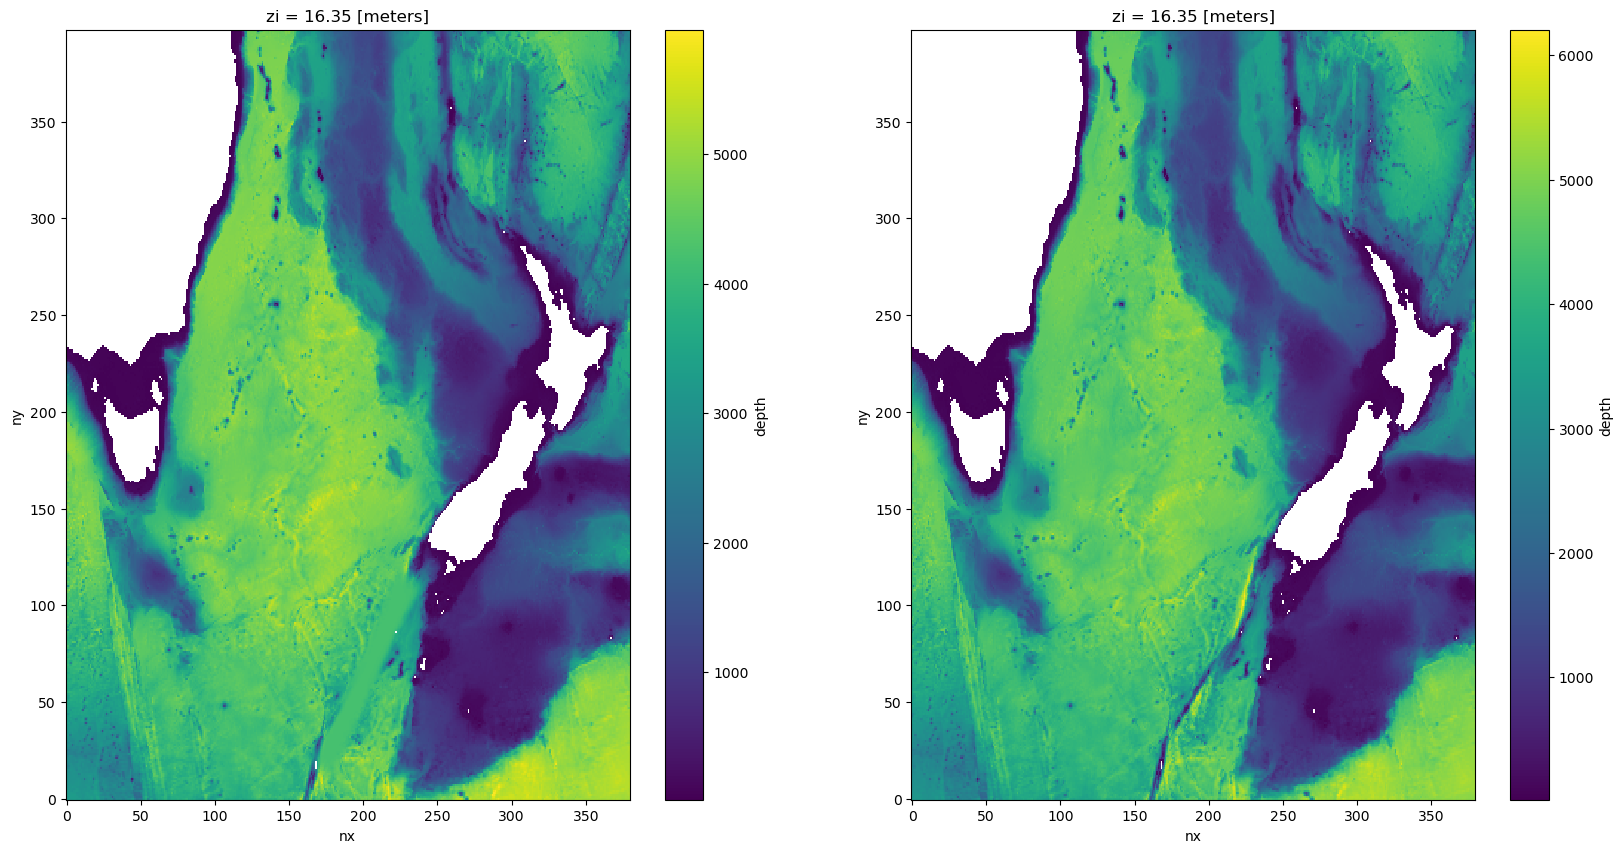

In [4]:
resolution = 10
expt = f'full-{resolution}'
inputdir = Path(f'/g/data/nm03/ab8992/ttide-inputs')

OgTopog = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'topog.nc'),chunks = "auto").load()

# Get the hgrid and the transect of topo
hgrid = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'hgrid.nc'),chunks = "auto")

OgTopog = OgTopog.assign_coords({
    "lat":(["ny"],hgrid.y.isel(nxp = 0)[1::2].values),
    "lon":(["nx"],hgrid.x.isel(nyp = 0)[1::2].values)
})
def m(a,b):
    return (b[1] - a[1]) / (b[0] - a[0])

def c(a,b):
    return a[1] - m(a,b) * a[0]
upper_left = (164.5,-46.5)
upper_right = (166.5,-47.5)
lower_left = (158,-55)
lower_right = (160,-55.5)
mask = OgTopog.depth
newtopog = OgTopog
width = 0.5
# distance = np.exp(-1 * np.abs(d.lat - d.lon * m(upper_left,upper_right) + c(upper_left,upper_right)))
mask = np.exp(-1 *((mask.lat - (mask.lon * m(upper_left,upper_right) + c(upper_left,upper_right)))/width)**2)
mask += np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,upper_left) + c(lower_left,upper_left)))/width)**2)
mask += np.exp(-1 *((mask.lat - (mask.lon * m(lower_right,upper_right) + c(lower_right,upper_right)))/width)**2)
mask += np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,lower_right) + c(lower_left,lower_right)))/width)**2)

# Now remove the corners
mask -= np.exp(-1 *((mask.lat - (mask.lon * m(upper_left,upper_right) + c(upper_left,upper_right)))/width)**2) * np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,upper_left) + c(lower_left,upper_left)))/width)**2)
mask -= np.exp(-1 *((mask.lat - (mask.lon * m(upper_left,upper_right) + c(upper_left,upper_right)))/width)**2) * np.exp(-1 *((mask.lat - (mask.lon * m(lower_right,upper_right) + c(lower_right,upper_right)))/width)**2)
mask -= np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,lower_right) + c(lower_left,lower_right)))/width)**2) * np.exp(-1 *((mask.lat - (mask.lon * m(lower_right,upper_right) + c(lower_right,upper_right)))/width)**2)
mask -= np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,lower_right) + c(lower_left,lower_right)))/width)**2) * np.exp(-1 *((mask.lat - (mask.lon * m(lower_left,upper_left) + c(lower_left,upper_left)))/width)**2)

mask = mask.where(
    (mask.lat < mask.lon * m(upper_left,upper_right) + c(upper_left,upper_right)) &
    (mask.lat < mask.lon * m(lower_left,upper_left) + c(lower_left,upper_left)) &
    (mask.lat > mask.lon * m(lower_right,upper_right) + c(lower_right,upper_right)) &
    (mask.lat > mask.lon * m(lower_left,lower_right) + c(lower_left,lower_right))
    ,1)


fig,ax = plt.subplots(1,2,figsize = (20,10))
(OgTopog.depth).plot(ax = ax[1])

newtopog["depth"] = OgTopog.depth * mask + (1 - mask) * 4200
newtopog.depth.plot(ax = ax[0])

# ax[0].set_xlim(300,500)
# ax[0].set_ylim(0,300)
# ax[1].set_xlim(300,500)
# ax[1].set_ylim(0,300)

newtopog.to_netcdf(f"/g/data/nm03/ab8992/ttide-inputs/{expt}/topog_noridge.nc",mode="w")